In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import aesthetics

aesthetics.activate_paper_rcParams('illustrator')

# Gene-SV distances

In this notebook, we established the distance between an SV and its nearest gene. This is relevant for noncoding gene set enrichment, as in that process we remove SVs that are too far from their nearest gene to have a reasonable effect.

# Read in our data

We read in the SVs here.

In [2]:
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.full_cohort.analysis_samples.sites.bed.gz"

In [3]:
# PREDICTED_NEAREST_TSS is the nearest gene, column index 42
svs = pd.read_csv(sv_path, sep="\t", usecols=[0, 1, 2, 3, 42])

In [4]:
svs.head(2)

,#chrom,start,end,name,PREDICTED_NEAREST_TSS
0,chr1,12000,30001,PedSV.2.5.2_CNV_chr1_1,OR4F5
1,chr1,12000,40001,PedSV.2.5.2_DUP_chr1_1,OR4F5


## Download genes

Next, we extract out the genic locations, for cross-reference. We use gencode.

In [5]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [6]:
# expand the gtf a bit
genes = gtf.query('feature == "gene"').reset_index(drop = True)

characteristics = {}
for index, row in genes.iterrows():
    
    # fetch gene attributes
    gene_data = row['attribute'].split('; ')
    gene_data = {field.split(' ')[0]: field.split(' ')[1].strip(';') for field in gene_data}
    gene_data = {key: val.strip('"') for key, val in gene_data.items()}
    characteristics[index] = gene_data
    
characteristics = pd.DataFrame(characteristics).T

genes = pd.concat([genes, characteristics], axis = 1)

In [7]:
# drop genes in PAR and require that they are protein coding
genes = genes[~(genes['tag'] == 'PAR')
              & (genes['gene_type'] == 'protein_coding')]

In [8]:
genes.shape

(20024, 17)

In [9]:
len(set(genes['gene_name'])), len(genes['gene_name'])

(20013, 20024)

So there are some duplicate gene names. We examine the duplicates in closer detail here:

In [10]:
gene_counts = genes['gene_name'].value_counts()
duplicates = gene_counts[gene_counts > 1]

# some heuristics to get proper genes
duplicate_gene_subset = genes[genes['gene_name'].isin(duplicates.index)]
duplicate_gene_subset.shape

(21, 17)

In [11]:
duplicate_gene_subset.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene_id,gene_type,gene_name,level,tag,hgnc_id,havana_gene,artif_dupl
5327,chr1,HAVANA,gene,235328570,235448952,.,+,.,"gene_id ""ENSG00000285053.1""; gene_type ""protei...",ENSG00000285053.1,protein_coding,TBCE,2,readthrough_gene,HGNC:11582,OTTHUMG00000192486.7,NaN
5331,chr1,HAVANA,gene,235367360,235452443,.,+,.,"gene_id ""ENSG00000284770.2""; gene_type ""protei...",ENSG00000284770.2,protein_coding,TBCE,2,overlapping_locus,HGNC:11582,OTTHUMG00000039987.14,NaN


In [12]:
# we choose level 1, then the overlapping locus
kept_duplicates = duplicate_gene_subset.sort_values(by = ['level', 'tag']).drop_duplicates(subset = ['gene_name'])
kept_duplicates.shape

(10, 17)

In [13]:
gene_reference = genes.drop_duplicates(subset = 'gene_name', keep = False)
gene_reference = pd.concat([gene_reference, kept_duplicates])

In [14]:
gene_reference.shape

(20013, 17)

# Quantify distances between non-coding SVs and their nearest genes

Downstream results will use this for filtering out noncoding SVs that are too far from their closest genes.

In [15]:
def calculate_distance(sv, gene):
    
    # If they overlap, the distance is 0
    if not (sv['end_sv'] < gene['start_gene'] or sv['start_sv'] > gene['end_gene']):
        return 0

    # If they do not overlap
    else:
        return min(abs(sv['start_sv'] - gene['end_gene']), abs(sv['end_sv'] - gene['start_gene']))

In [16]:
# examine intergenic svs
intergenic_svs = svs[~pd.isnull(svs['PREDICTED_NEAREST_TSS'])]

# drop those labelled as affecting two genes
intergenic_svs = intergenic_svs[~intergenic_svs['PREDICTED_NEAREST_TSS'].str.contains(',')]

# drop those affecting genes not in our reference
intergenic_svs = intergenic_svs[intergenic_svs['PREDICTED_NEAREST_TSS'].isin(gene_reference['gene_name'].tolist())]

# merge with gene locations
intergenic_svs = intergenic_svs.merge(gene_reference[['seqname', 'start', 'end', 'gene_name']], 
                                 left_on = 'PREDICTED_NEAREST_TSS', 
                                 right_on = 'gene_name',
                                     suffixes = ['_sv', '_gene'])

# check that all chroms are the same
assert (intergenic_svs['#chrom'] == intergenic_svs['seqname']).all()

# get the gene and SV locations
sv_locs = intergenic_svs[['start_sv', 'end_sv']]
gene_locs = intergenic_svs[['start_gene', 'end_gene']]

# calculate the distances
distances = np.array([calculate_distance(sv, gene) for sv, gene in zip(sv_locs.to_dict('records'), gene_locs.to_dict('records'))])

# for the purpose of viewing a histogram, truncate the distances
truncated_distances = distances.copy()
truncated_distances[truncated_distances > 5e5] = 5e5


In [17]:
# what percentage of noncoding SVs are more than 500 kb from their nearest gene?
(truncated_distances == 5e5).mean()

0.16316536862446565

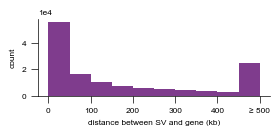

In [18]:
fig, ax = plt.subplots(1, figsize = (3, 1))
ax.hist(truncated_distances)
ax.set_xlabel('distance between SV and gene (kb)')
ax.set_ylabel('count')
ax.set_xticks([0, 1e5, 2e5, 3e5, 4e5, 5e5])
ax.set_xticklabels([0, 100, 200, 300, 400, '≥ 500'])
sns.despine()
fig.savefig('figures/distance-between-intergenic-svs-and-genes.png', bbox_inches = 'tight')

Now export

In [19]:
intergenic_svs['distance'] = distances

In [20]:
intergenic_svs[['name', '#chrom', 'start_sv', 'end_sv', 'gene_name', 'start_gene', 'end_gene', 'distance']].to_csv('data/cwas/intergenic-sv-to-gene-distances.csv', index = False)